In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np

## Create our custom datset object

In [3]:
class MassachusettsRoadsDataset(Dataset):
    """
    Massachusetts Roads Dataset
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(((".tiff")))])
    
    def __len__(self):
        return len(self.images)     
    
    def __getitem__(self, idx: int):
        #Load image and mask
        img_path = os.path.join(self.image_dir, self.images[idx])
        #Labels in the Massachusets
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".tiff", ".tif"))
        image = Image.open(img_path).convert("RGB")
        #Get the label in grayscale
        mask = Image.open(mask_path).convert("L")
        #Convert image and mask to array in case augmentation using albumentations
        image = np.array(image)
        mask = np.array(mask)
        # Normalize mask to range [0, 1]
        mask = (mask // 255).astype(np.uint8)  #     Map 255 to 1, 0 remains 0

        #Apply transform with Albumentation (remember Albumentations needs np.arrays!)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            #mask = augmented['mask']
            mask = torch.tensor(augmented['mask'], dtype=torch.long)
        else:
            #Conver to tensor
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)/255
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask, self.images[idx]
 


## Create dataloaders

In [4]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

bs = 32 #batch size

tr_img_dir = "dataset/tiff/train"
tr_mask_dir = "dataset/tiff/train_labels"
val_img_dir = "dataset/tiff/val"
val_mask_dir = "dataset/tiff/val_labels"
test_img_dir = "dataset/tiff/test"
test_mask_dir = "dataset/tiff/test_labels"

# Definir transformaciones
transform = A.Compose([
    A.Resize(512, 512),  # Resize
    # A.HorizontalFlip(p=0.5),  # Horizontal Flip
    # A.RandomBrightnessContrast(p=0.2),  # Adjust brightness/contrast
    # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.4),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.4), #Shift, scale and rotate an image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImgNet normalization values
    ToTensorV2()  # Convertir a tensores
])

#Create datasets
tr_ds = MassachusettsRoadsDataset(tr_img_dir, tr_mask_dir, transform)
val_ds = MassachusettsRoadsDataset(val_img_dir, val_mask_dir, transform)
test_ds = MassachusettsRoadsDataset(test_img_dir, test_mask_dir)
#Create dataloaders (random split)
tr_dl = DataLoader(tr_ds, bs, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, bs, shuffle=True, num_workers=4)
test_dl = DataLoader(val_ds, 1, shuffle=False, num_workers=4)

## Data visualization

In [5]:
def denormalize_image(tensor):
    # Tensor images in PyTorch are [C x H x W]
    # Imagenet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Denormalization: multiply by std and sum mean
    image_np = tensor.cpu().detach().squeeze().permute(1, 2, 0).numpy()  #Convert tu numpy HWC
    image_np = image_np * std + mean  
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)  # Scale to rage 0-255 and convert to uint8
    
    return image_np


In [6]:
from matplotlib import pyplot as plt
import random

def visualize_data(data, n_imgs, rows, is_batch=False):
    """
    Visualize images and masks from a dataset or DataLoader batch.
    
    Parameters:
    - data: Dataset object or DataLoader batch (tuple of images, masks, names).
    - n_imgs: Number of images and masks to visualize.
    - rows: Number of rows in the visualization grid.
    - is_batch: Boolean flag indicating if data comes from a batch (default: False).
    """
    # Handle batch or dataset input
    if is_batch:
        batch_images, batch_masks, batch_names = next(iter(data))
        images = batch_images[:n_imgs]
        masks = batch_masks[:n_imgs]
        names = batch_names[:n_imgs]
    else:
        # Random indices for plotting
        indices = [random.randint(0, len(data) - 1) for _ in range(n_imgs)]
        images, masks, names = zip(*[data[idx] for idx in indices])
    
    # Create two figures for images and masks
    fig_images = plt.figure(figsize=(20, 10))
    fig_masks = plt.figure(figsize=(20, 10))
    
    for i in range(n_imgs):
        # Retrieve image and mask
        img_tensor = images[i]
        mask_tensor = masks[i]
        img_name = names[i]
        
        # Convert image and mask to numpy arrays for visualization
        img = denormalize_image(img_tensor) if is_batch else img_tensor.permute(1, 2, 0).numpy()  # CHW to HWC
        mask = mask_tensor.numpy()  # Masks are grayscale
        
        # Add image to the first figure
        plt.figure(fig_images.number)
        plt.subplot(rows, n_imgs // rows, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {img_name}")
        
        # Add mask to the second figure
        plt.figure(fig_masks.number)
        plt.subplot(rows, n_imgs // rows, i + 1)
        plt.imshow(mask, cmap="gray")
        plt.axis("off")
        plt.title(f"Mask {img_name}")
    
    # Show both figures
    fig_images.suptitle("Images", fontsize=16)
    fig_masks.suptitle("Masks", fontsize=16)
    fig_images.tight_layout()
    fig_masks.tight_layout()
    plt.show()

### Visualize images from the dataset (not augmented)

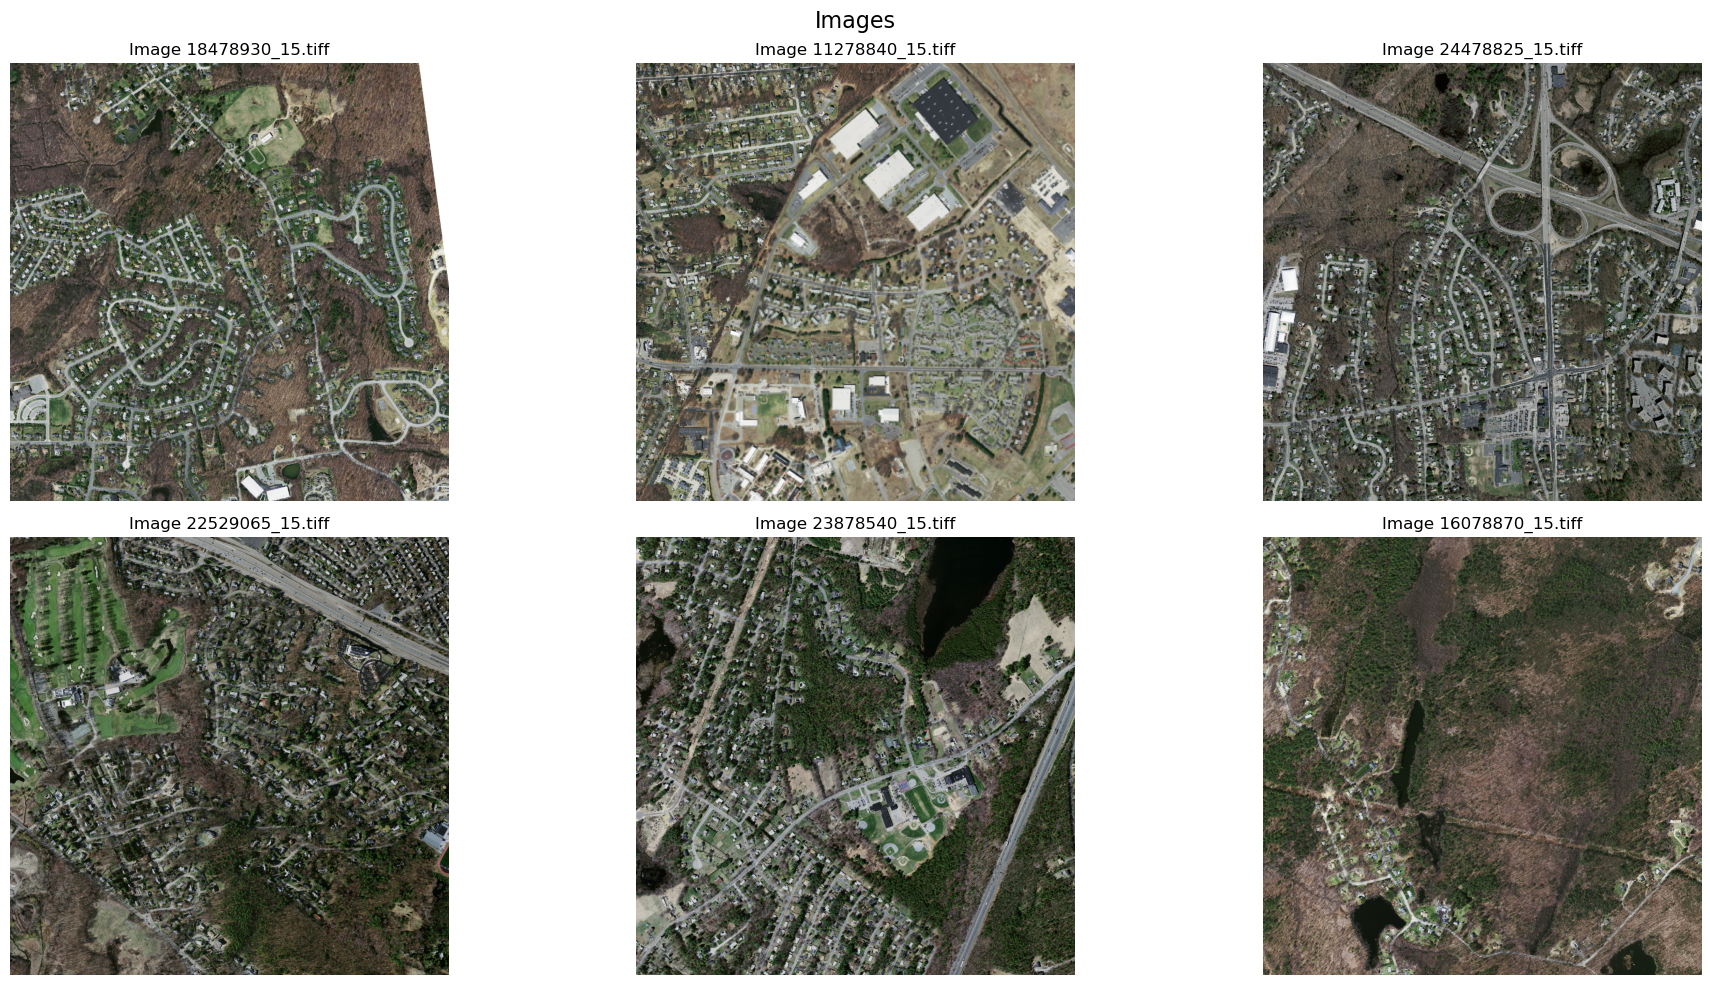

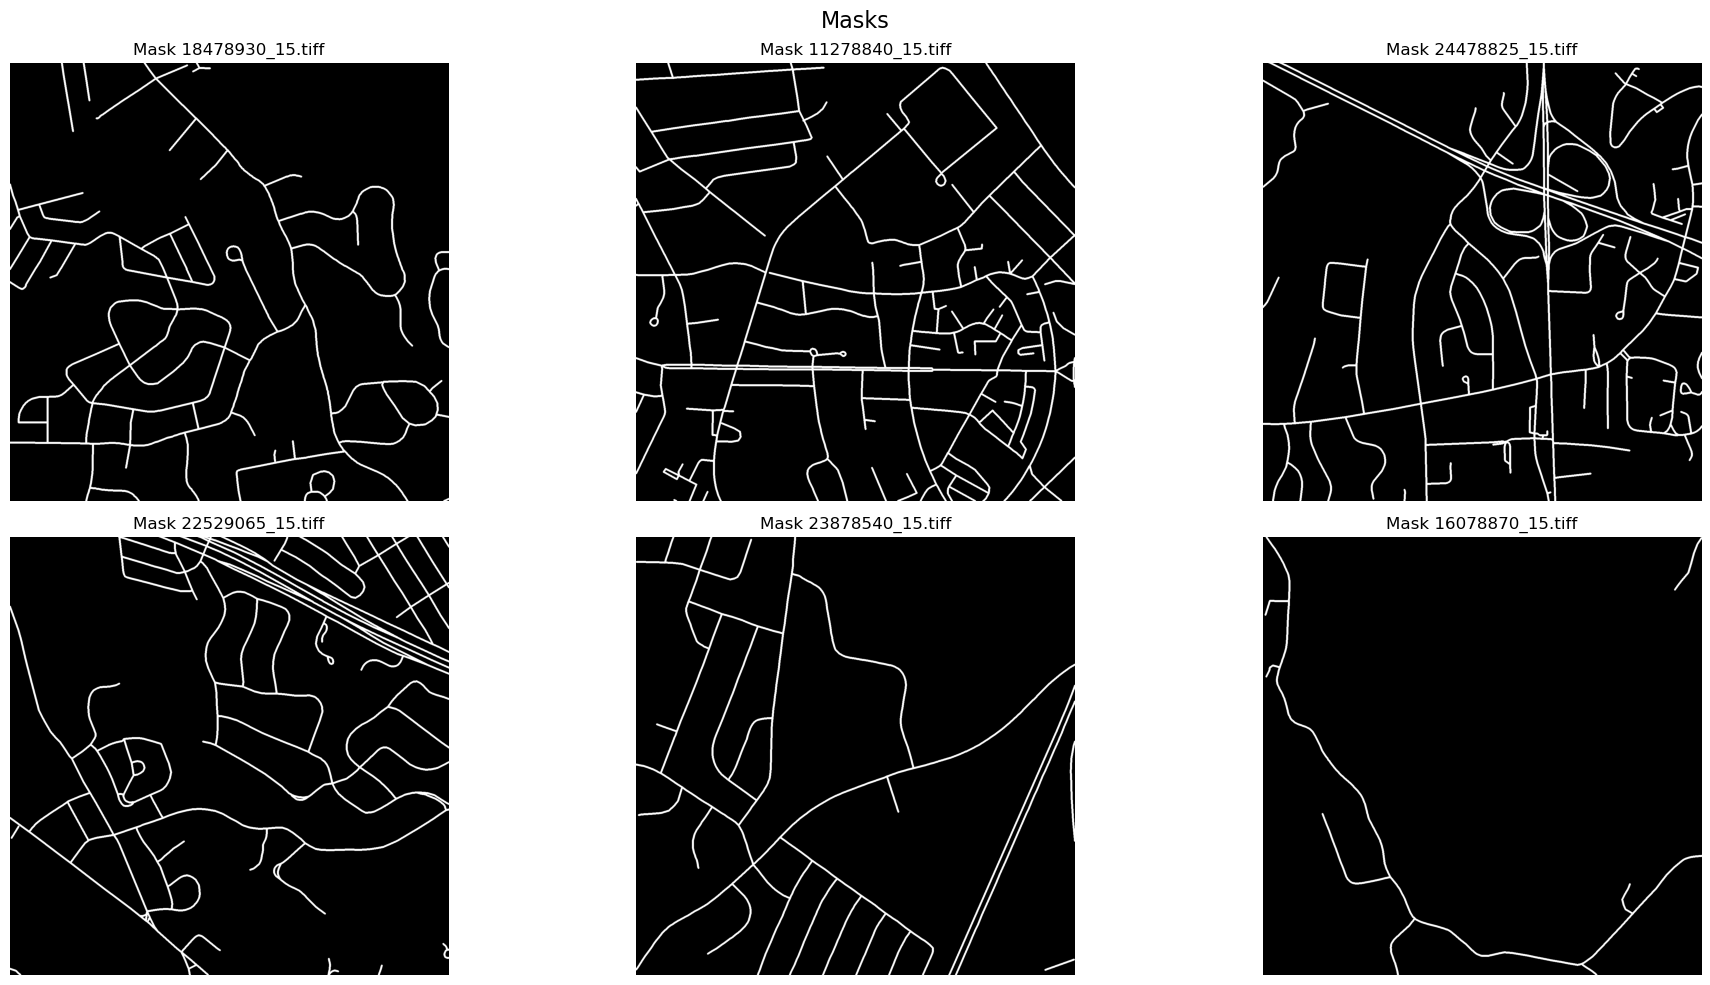

In [7]:
visualize_data(data=test_ds, n_imgs=6, rows=2) #Test not transformed, that's why we viz that


### Visualize images from the dataloaders (with augmentations)

/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sour

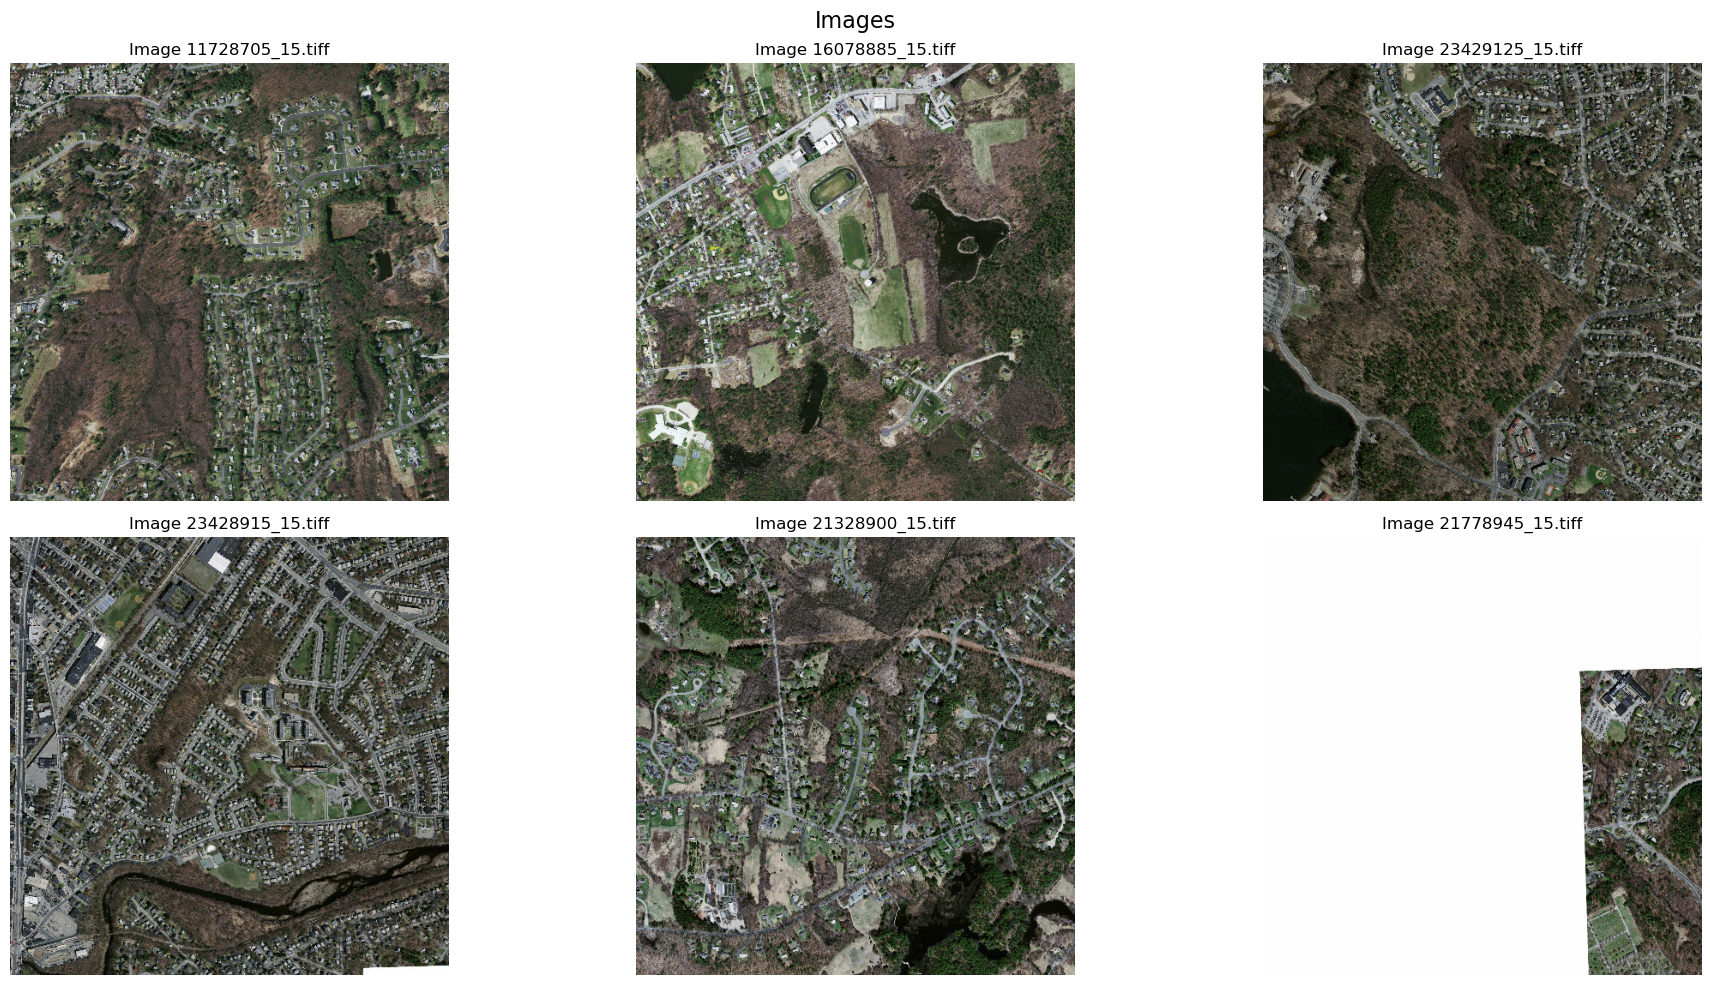

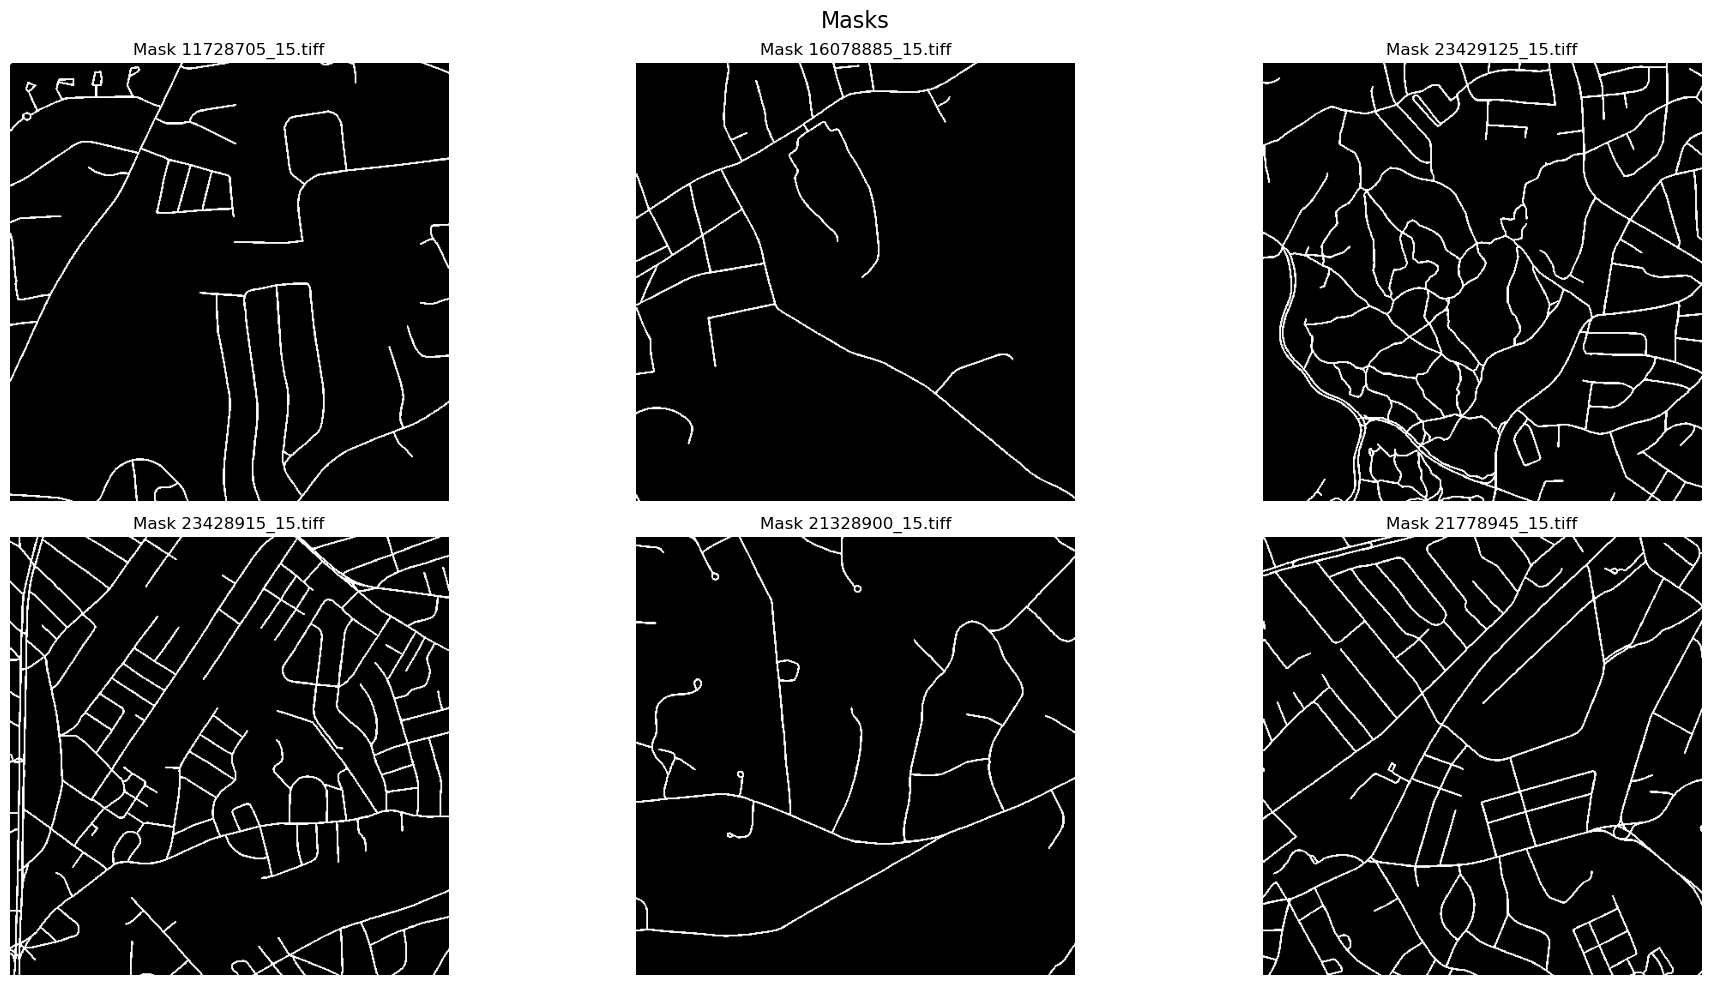

In [8]:
visualize_data(tr_dl, 6, 2,is_batch=True) #is_batch=True is for dataloaders with aug

In [9]:
import importlib
import src.metrics, src.training_seg  # Suponiendo que este es tu módulo
importlib.reload(src.metrics)  # Recarga el módulo para reflejar cambios
importlib.reload(src.training_seg)

<module 'src.training_seg' from '/home/edu_pc/Projects/Road_Segmentation/src/training_seg.py'>

In [10]:
torch.cuda.empty_cache()

### Model definition and training

In [ ]:
import segmentation_models_pytorch as smp
from src.training_seg import *
from torch.amp import GradScaler

#Definition of all the hyperparameters and other info to track
hyperparams = {
    "experiment_name": "Road Segmentation - Massachusets",
    "lr": 1e-3,
    "bs": bs,  # Defined when creating the dataloaders
    "epochs": 15,
    "optimizer": "Adam",
    "scheduler": "StepLR",
    "precision FP16": True,
    "model_type": "DeepLabV3+",
    "encoder_name": "efficientnet-b4",
    "num_classes": 2,
    "patience": 5
}
#Initialize a variable to track validation loss (used for saving best model)
best_val_loss = float("inf")
counter = 0 # Counte for early stop
#Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
#Define the model
model = smp.DeepLabV3Plus(
    #encoder_name=hyperparams["encoder_name"],
    #encoder_weights="imagenet",
    #in_channels=3,
    classes=hyperparams["num_classes"]
)
#Initialize MLflow
mlflow.set_experiment(hyperparams["experiment_name"])

with mlflow.start_run(run_name="Road Segmentation - Massachusets") as run:
    #Log hyperparams
    mlflow_log_hyp(hyperparams)
    #Get therun ID
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")


#Initialize setup for our transfer learning
model, epochs, device,  loss_fn, optimizer, scheduler = setup_train(model, device, hyperparams)
#Create GradScaler for FP16 mixup calcs
scaler = GradScaler()

for epoch in range(epochs):
    #Train Step
    train_metrics = train_one_epoch(model, tr_dl, device, loss_fn, optimizer, scaler, epoch)
    #Val step
    val_metrics = val_one_epoch(model, val_dl, device, loss_fn, epoch)
    #Print metrics
    print(f"Epoch {epoch + 1}: {train_metrics} | {val_metrics}")
    #Save model if val_loss is better tha previous epoch
    save_best_model(model, val_metrics, best_val_loss, hyperparams["experiment_name"], run_id, epoch)

    #Early stop check and saving checkpoint if val loss is better
    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]  #Update best val
        counter = 0  #Reset to 0
        model_path = f"saved_models/best_model_{hyperparams['experiment_name']}_run_{run_id}.pth"
        #Save the model
        torch.save(model.state_dict(), model_path)
        #Log the model as a MLflow artifact
        mlflow.log_artifact(model_path)
        print(f"Epoch {epoch + 1}: Validation loss improved to {best_val_loss:.4f}, saving model...")
    else:
        counter += 1  # Counter goes up
        print(f"Epoch {epoch + 1}: No improvement in validation loss. Counter: {counter}/{hyperparams["patience"]}")
    
    # Check early stopping condition
    if counter >= hyperparams["patience"]:
        #Log if early stop happened
        mlflow.log_metric("early_stopping_epoch", epoch + 1)
        mlflow.log_param("early_stopping_triggered", True)
        print(f"Stopping early at epoch {epoch + 1}. Best validation loss: {best_val_loss:.4f}")
        break  # Exit training

#During our training, we are creating a summarywriter object for tensorboad. Once train is finished, close it.    
#Good practice is to clear memory
mlflow.end_run()
del optimizer
del loss_fn
del scaler
torch.cuda.empty_cache()


2025/04/09 12:59:17 INFO mlflow.tracking.fluent: Experiment with name 'Road Segmentation - Massachusets' does not exist. Creating a new experiment.


Run ID: 92437206d7204b979e768e2a014e2661


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 1: {'train_loss': 0.28467910076890673, 'train_miou': tensor(0.0052, device='cuda:0'), 'train_dice': tensor(0.0119, device='cuda:0'), 'train_PA': tensor(0.9498, device='cuda:0'), 'train_time': 21.257270097732544} | {'val_loss': 0.7359250783920288, 'val_miou': tensor(0.0432, device='cuda:0'), 'val_dice': tensor(0.0906, device='cuda:0'), 'val_PA': tensor(0.8681, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 1


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 2: {'train_loss': 0.1463550818817956, 'train_miou': tensor(0.0730, device='cuda:0'), 'train_dice': tensor(0.1391, device='cuda:0'), 'train_PA': tensor(0.9594, device='cuda:0'), 'train_time': 20.107243299484253} | {'val_loss': 0.17998985946178436, 'val_miou': tensor(0.0393, device='cuda:0'), 'val_dice': tensor(0.0826, device='cuda:0'), 'val_PA': tensor(0.9320, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 2


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 3: {'train_loss': 0.13589913227728434, 'train_miou': tensor(0.0491, device='cuda:0'), 'train_dice': tensor(0.0983, device='cuda:0'), 'train_PA': tensor(0.9462, device='cuda:0'), 'train_time': 20.459656715393066} | {'val_loss': 0.21205952763557434, 'val_miou': tensor(0.1543, device='cuda:0'), 'val_dice': tensor(0.2892, device='cuda:0'), 'val_PA': tensor(0.9209, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 3


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 4: {'train_loss': 0.12998185881546565, 'train_miou': tensor(0.1051, device='cuda:0'), 'train_dice': tensor(0.1969, device='cuda:0'), 'train_PA': tensor(0.9582, device='cuda:0'), 'train_time': 20.982670068740845} | {'val_loss': 0.16357572376728058, 'val_miou': tensor(0.1442, device='cuda:0'), 'val_dice': tensor(0.2582, device='cuda:0'), 'val_PA': tensor(0.9338, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 4


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 5: {'train_loss': 0.12578132322856359, 'train_miou': tensor(0.1052, device='cuda:0'), 'train_dice': tensor(0.1916, device='cuda:0'), 'train_PA': tensor(0.9476, device='cuda:0'), 'train_time': 20.7143874168396} | {'val_loss': 0.15956223011016846, 'val_miou': tensor(0.1289, device='cuda:0'), 'val_dice': tensor(0.2344, device='cuda:0'), 'val_PA': tensor(0.9342, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 5


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 6: {'train_loss': 0.12212792124067035, 'train_miou': tensor(0.1659, device='cuda:0'), 'train_dice': tensor(0.2824, device='cuda:0'), 'train_PA': tensor(0.9673, device='cuda:0'), 'train_time': 21.297778844833374} | {'val_loss': 0.16127106547355652, 'val_miou': tensor(0.1208, device='cuda:0'), 'val_dice': tensor(0.2220, device='cuda:0'), 'val_PA': tensor(0.9336, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 6


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 7: {'train_loss': 0.11932064103228705, 'train_miou': tensor(0.1945, device='cuda:0'), 'train_dice': tensor(0.3270, device='cuda:0'), 'train_PA': tensor(0.9686, device='cuda:0'), 'train_time': 22.054484367370605} | {'val_loss': 0.15312516689300537, 'val_miou': tensor(0.1669, device='cuda:0'), 'val_dice': tensor(0.2925, device='cuda:0'), 'val_PA': tensor(0.9366, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 7


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 8: {'train_loss': 0.11654938140085765, 'train_miou': tensor(0.1944, device='cuda:0'), 'train_dice': tensor(0.3424, device='cuda:0'), 'train_PA': tensor(0.9609, device='cuda:0'), 'train_time': 21.566701650619507} | {'val_loss': 0.15076296031475067, 'val_miou': tensor(0.1521, device='cuda:0'), 'val_dice': tensor(0.2691, device='cuda:0'), 'val_PA': tensor(0.9366, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 8


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 9: {'train_loss': 0.1142470338514873, 'train_miou': tensor(0.1831, device='cuda:0'), 'train_dice': tensor(0.3149, device='cuda:0'), 'train_PA': tensor(0.9497, device='cuda:0'), 'train_time': 20.037795305252075} | {'val_loss': 0.17757883667945862, 'val_miou': tensor(0.2007, device='cuda:0'), 'val_dice': tensor(0.3450, device='cuda:0'), 'val_PA': tensor(0.9368, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 9


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 10: {'train_loss': 0.11170379157577243, 'train_miou': tensor(0.2014, device='cuda:0'), 'train_dice': tensor(0.3349, device='cuda:0'), 'train_PA': tensor(0.9591, device='cuda:0'), 'train_time': 24.521259546279907} | {'val_loss': 0.14553706347942352, 'val_miou': tensor(0.2165, device='cuda:0'), 'val_dice': tensor(0.3696, device='cuda:0'), 'val_PA': tensor(0.9398, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 10


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 11: {'train_loss': 0.10866787667785371, 'train_miou': tensor(0.2631, device='cuda:0'), 'train_dice': tensor(0.4291, device='cuda:0'), 'train_PA': tensor(0.9606, device='cuda:0'), 'train_time': 22.01084065437317} | {'val_loss': 0.14321836829185486, 'val_miou': tensor(0.2661, device='cuda:0'), 'val_dice': tensor(0.4330, device='cuda:0'), 'val_PA': tensor(0.9416, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 11


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 12: {'train_loss': 0.10678179051194872, 'train_miou': tensor(0.2123, device='cuda:0'), 'train_dice': tensor(0.3295, device='cuda:0'), 'train_PA': tensor(0.9615, device='cuda:0'), 'train_time': 20.917673587799072} | {'val_loss': 0.1401633322238922, 'val_miou': tensor(0.2854, device='cuda:0'), 'val_dice': tensor(0.4533, device='cuda:0'), 'val_PA': tensor(0.9422, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 12


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 13: {'train_loss': 0.10500328136341912, 'train_miou': tensor(0.2582, device='cuda:0'), 'train_dice': tensor(0.3905, device='cuda:0'), 'train_PA': tensor(0.9599, device='cuda:0'), 'train_time': 21.007412672042847} | {'val_loss': 0.13968297839164734, 'val_miou': tensor(0.3164, device='cuda:0'), 'val_dice': tensor(0.4843, device='cuda:0'), 'val_PA': tensor(0.9429, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 13


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 14: {'train_loss': 0.10330222972801753, 'train_miou': tensor(0.2639, device='cuda:0'), 'train_dice': tensor(0.3970, device='cuda:0'), 'train_PA': tensor(0.9515, device='cuda:0'), 'train_time': 22.685583353042603} | {'val_loss': 0.14984190464019775, 'val_miou': tensor(0.2170, device='cuda:0'), 'val_dice': tensor(0.3626, device='cuda:0'), 'val_PA': tensor(0.9409, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 14


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_188917/3079702348.py:33: UserWarning: To copy construct from a

Epoch 15: {'train_loss': 0.10248700337750571, 'train_miou': tensor(0.3016, device='cuda:0'), 'train_dice': tensor(0.4523, device='cuda:0'), 'train_PA': tensor(0.9628, device='cuda:0'), 'train_time': 20.96865439414978} | {'val_loss': 0.1429554671049118, 'val_miou': tensor(0.2626, device='cuda:0'), 'val_dice': tensor(0.4182, device='cuda:0'), 'val_PA': tensor(0.9420, device='cuda:0')}
Saved new best model for experiment 'Road Segmentation - Massachusets', run 92437206d7204b979e768e2a014e2661, epoch 15


In [11]:
# Cargar una máscara y verificar su tipo y valores únicos
from torchvision.transforms import ToTensor
import torch

# Instanciar tu dataset
mask_dir = "dataset/tiff/train_labels"  # Cambia al directorio de las máscaras
img_dir = "dataset/tiff/train"          # Cambia al directorio de las imágenes
dataset = MassachusettsRoadsDataset(img_dir, mask_dir)

# Seleccionar una muestra (idx=0 como ejemplo)
image, mask, filename = dataset[3]  # Cambia el índice según lo necesites

# Mostrar el nombre de la máscara
print(f"Mask filename: {filename}")

# Verificar tipo de la máscara
print(f"Mask dtype: {mask.dtype}")  # Debe ser torch.int64

# Verificar valores únicos
print(f"Unique values in mask: {torch.unique(mask)}")  # Esto muestra los valores presentes (por ejemplo, 0, 1 para binario)

Mask filename: 20878915_15.tiff
Mask dtype: torch.int64
Unique values in mask: tensor([  0, 255])


In [16]:
model.to(device)

def preprocess_image(image_path):
    # Define los mismos transformaciones usadas en el entrenamiento
    preprocess = A.Compose([
        A.Resize(512, 512),  # Redimensionar al tamaño esperado
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizar
        A.ToTensorV2(),          # Convertir a tensor
    ])
    image = Image.open(image_path).convert("RGB")  # Abrir imagen como RGB
    image = np.array(image)
    # Aplica la transformación y extrae el tensor de imagen
    transformed = preprocess(image=image)
    tensor_image = transformed['image']
    return tensor_image.unsqueeze(0)  # Añadir batch dimension

image_path = "dataset/tiff/test/10378780_15.tiff"  # Cambia al path de tu imagen de prueba
input_image = preprocess_image(image_path).to(device)

In [17]:
# Realizar inferencia
with torch.no_grad():
    output = model(input_image)  # Inferencia
    prediction = torch.argmax(output, dim=1).squeeze(0)  # Convertir a máscara de clase

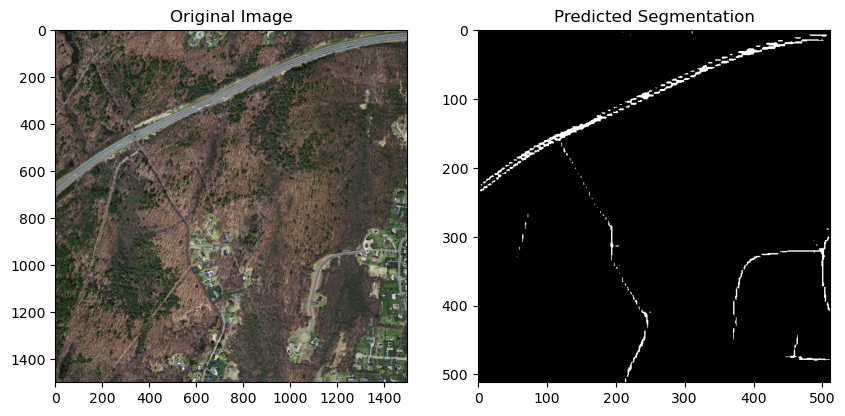

In [18]:
import matplotlib.pyplot as plt

def visualize_results(image_path, prediction):
    original_image = Image.open(image_path)
    plt.figure(figsize=(10, 5))
    
    # Imagen original
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    
    # Máscara predicha
    plt.subplot(1, 2, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(prediction.cpu().numpy(), cmap="gray")
    
    plt.show()

visualize_results(image_path, prediction)